In [1]:
import sys
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tslearn.clustering import TimeSeriesKMeans
from sklearn.model_selection import train_test_split
import seaborn as sns
import utils
from importlib import reload
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from datetime import datetime



2023-09-15 22:44:05.339921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 22:44:06.510090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f000e34fd90>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, 

In [2]:
print("HELLOAS")
feature_list = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6',
                'PctChgVol','sumPctChgVol_2','sumPctChgVol_3','sumPctChgVol_4','sumPctChgVol_5','sumPctChgVol_6',
                'PctChgVix','sumPctChgVix_2','sumPctChgVix_3','sumPctChgVix_4','sumPctChgVix_5','sumPctChgVix_6','Close','Volume']
# feature_list = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6','Close']
n_steps = 30

features = len(feature_list)
run_name = datetime.today().strftime('%Y-%m-%d_%H-%M')
run_number = 0
tstart = 2010
tend = 2020

# tickerList = ['aapl','spy','amd','qqq','amzn','meta','msft','f']
# tickerList = ['aapl','spy','amd','qqq']
tickerList = ['aapl']

trend_features = ['Close','Volume']
pctChg_features = [f for f in feature_list if f not in trend_features]
cluster_features = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6']
# cluster_features = ['PctChgClCl']

predictive_features = ['PctChgClCl','sumPctChgClCl_2','sumPctChgClCl_3','sumPctChgClCl_4','sumPctChgClCl_5','sumPctChgClCl_6']

remaining_features = [f for f in feature_list if f not in predictive_features and f not in trend_features]

print("HELLOAS")



HELLOAS
HELLOAS


In [3]:
run_path = "ClusterRuns/"+run_name+"/"+str(run_number)

if not os.path.exists(run_path):
    os.makedirs(run_path)

# Construct file name
file_name = os.path.join(run_path, "results.txt")

# Create and open the run_number.txt file for writing

run_info = ""
run_info += "Tickers: " + str(tickerList) + "\n"
run_info += "cluster_features: " + str(cluster_features) + "\n"
run_info += "n_steps: " + str(n_steps)+ "\n"
run_info += "Start: " + str(tstart) + " end: " + str(tend) + "\n\n"

with open(file_name, 'w') as file:
    file.write(run_info)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


array([0.84477514, 0.64236138, 0.78292423, 1.        , 1.        ,
       0.8953707 ])

(2734, 6)

array([-4.39795464e-01, -2.66161801e-01, -1.12147874e-01, -2.54202799e-02,
       -3.21204099e-01, -3.86690867e-01,  8.34128230e-02, -8.07268202e-02,
       -1.14419769e-01, -9.71712194e-03, -6.30644876e-02, -1.61221746e-01,
        4.90743770e-02,  5.75044650e-02, -3.02285649e-01,  6.97247632e-02,
        4.92603240e-02, -4.49192399e-02,  1.19900002e+02,  8.56719000e+07])

(615, 6)

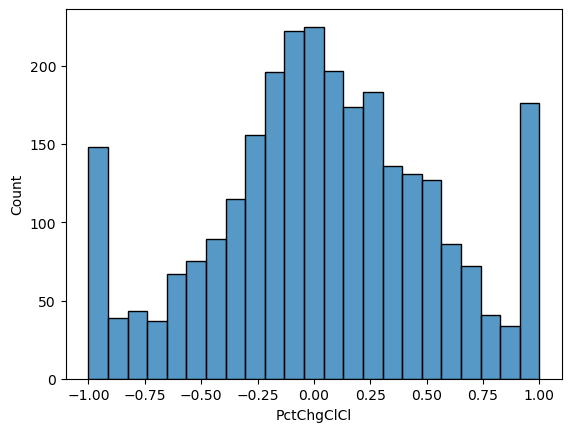

In [4]:

reload(utils)
combined_train_df = pd.DataFrame()
combined_test_df = pd.DataFrame()
all_train = [] 
all_test = []

for ticker in tickerList:
    df = utils.prepareStockDf(ticker,tstart)
    training_set, test_set = utils.train_test_split(df,tstart, tend, feature_list)
    test_set = test_set.iloc[n_steps:,:] # Remove the first n_steps rows from the test set
    combined_train_df = pd.concat([combined_train_df,training_set],axis=0)
    combined_test_df = pd.concat([combined_test_df,test_set],axis=0)
    all_train.append(training_set)
    all_test.append(test_set)

predictiveScaler = utils.CustomScaler()
remainingScaler = utils.CustomScaler() 

predictiveScaler.fit(combined_train_df[predictive_features])
# combined_train_df[predictive_features] = predictiveScaler.transform(combined_train_df[predictive_features])
# combined_test_df[predictive_features] = predictiveScaler.transform(combined_test_df[predictive_features])

remainingScaler.fit(combined_train_df[remaining_features])
# combined_train_df[remaining_features] = remainingScaler.transform(combined_train_df[remaining_features])
# combined_test_df[remaining_features] = remainingScaler.transform(combined_test_df[remaining_features])



# Initialize arrays as empty arrays with the necessary number of dimensions
X_train, X_test = np.empty((0, n_steps, len(feature_list))), np.empty((0, n_steps, len(feature_list)))
y_train, y_test = np.empty((0, 6)), np.empty((0, 6))

for i,val in enumerate(all_train): 
    
    training_set = all_train[i]
    test_set = all_test[i]

    training_set[predictive_features] = predictiveScaler.transform(training_set[predictive_features])
    training_set[remaining_features] = remainingScaler.transform(training_set[remaining_features])

    test_set[predictive_features] = predictiveScaler.transform(test_set[predictive_features])
    test_set[remaining_features] = remainingScaler.transform(test_set[remaining_features])
    
    sns.histplot(training_set['PctChgClCl'])
    cur_X_train, cur_y_train = utils.split_sequence(training_set.values, n_steps)
    cur_X_test, cur_y_test = utils.split_sequence(test_set.values, n_steps)

    # Append cur_X_train, cur_X_test, cur_y_train, cur_y_test to the total arrays
    X_train = np.concatenate((X_train, cur_X_train), axis=0)
    X_test = np.concatenate((X_test, cur_X_test), axis=0)
    y_train = np.concatenate((y_train, cur_y_train), axis=0)
    y_test = np.concatenate((y_test, cur_y_test), axis=0)





display(y_test[2])
display(y_train.shape)
display(X_test[0,-1,:])
display(y_test.shape)


In [5]:

trend_feature_index = [feature_list.index(trend) for trend in trend_features]

X_train = utils.scale_patterns(X_train,trend_feature_index)
display(X_train[0:1,:,-1])

array([[0.08242401, 0.15469748, 0.12146223, 0.07133437, 0.05161135,
        0.06137839, 0.14972323, 0.15736138, 0.04177883, 0.14946133,
        0.24028487, 0.16154432, 0.15887293, 0.341678  , 0.46456572,
        1.        , 0.90342959, 0.53659038, 0.58499531, 0.25355952,
        0.21912888, 0.16366572, 0.25875451, 0.32065857, 0.07209575,
        0.17539701, 0.        , 0.12025   , 0.19048439, 0.1158351 ]])

In [6]:
cluster_feature_index = [feature_list.index(cluster_feature) for cluster_feature in cluster_features]
X_cluster = utils.create_Cluster_Seq(X_train,cluster_feature_index)
display(X_cluster.shape)
display(X_cluster[0:1,:,-1])


(2734, 30, 6)

array([[ 0.79316681,  0.3486252 , -0.03580195,  0.10069045,  0.02572987,
        -0.03590993, -0.40315357, -0.23443758, -0.09655431, -0.29916891,
         0.21325223,  0.12367827,  0.0430979 , -0.82530774, -0.3796251 ,
         0.04085056, -0.43378429, -0.78725228, -1.        , -0.18052503,
        -0.46815391, -0.42626184, -1.        , -0.24061334,  0.16047911,
         0.11633465, -0.03711717, -0.02365182,  0.58495514,  0.54836361]])

In [7]:
import math
n_clusters = math.ceil(math.sqrt(len(X_cluster))) // 3
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=n_clusters)

labels = km.fit_predict(X_cluster)

In [8]:
reload(utils)
threshold_factor = .5 # Adjust as necessary

X_cluster_adj, X_train_adj, y_train_adj, labels_adj = utils.remove_outliers(X_cluster,X_train,y_train,labels,km,threshold_factor)
display(X_cluster.shape)
display(X_train.shape)
display(y_train.shape)
display(X_cluster_adj.shape)
display(X_train_adj.shape)
display(y_train_adj.shape)
display(labels_adj.shape)

(2734, 30, 6)

(2734, 30, 20)

(2734, 6)

(2271, 30, 6)

(2271, 30, 20)

(2271, 6)

(2271,)

In [ ]:
reload(utils)
utils.visualizeData(labels_adj,X_cluster_adj)


In [10]:
# cluster_assignments = km.predict(X_test)
# set(cluster_assignments)

In [11]:
import pickle 
visualDict = {'labels': labels_adj, 'X_train':X_cluster_adj}
pickle_name = os.path.join(run_path, "X_train.pkl")

with open(pickle_name, 'wb') as file:
    pickle.dump(visualDict,file)

In [12]:
if len(y_train.shape) == 1:
    df = pd.DataFrame({'label': labels_adj, 'target': y_train_adj})
else:
    # Convert the 2D y_train into a DataFrame
    y_df = pd.DataFrame(y_train_adj, columns=[f'target_{i}' for i in range(y_train_adj.shape[1])])
    df = pd.concat([pd.DataFrame({'label': labels_adj}), y_df], axis=1)

df.head()
display(df['label'].value_counts())


5     221
0     216
6     206
4     158
10    156
15    136
7     126
12    118
11    114
9     111
13    109
1     109
3     105
8     103
14    103
2      90
16     90
Name: label, dtype: int64

In [13]:
# display(X_train.shape)
# display(y_train.mean())
# display(cluster_X_train[0])

# label_filter = 1
# filtered_x_train, filtered_y_train = utils.filter_clusters(labels,label_filter,X_train_scaled,y_train_scaled)
# filtered_x_train.shape

In [14]:
def create_model():
    model_lstm = Sequential()

    # Using Bidirectional LSTM for the first layer
    model_lstm.add(Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True), input_shape=(None, features)))
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(GRU(units=250, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(GRU(units=100, activation='tanh', return_sequences=True))  # Changed number of units to 250
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(LSTM(units=100, activation='tanh'))  # Changed number of units to 100
    model_lstm.add(BatchNormalization())  # Batch normalization
    model_lstm.add(Dropout(0.2))

    model_lstm.add(Dense(units=6))

    # Using Adam optimizer with a learning rate scheduler
    optimizer = Adam(learning_rate=0.001)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-5)

    model_lstm.compile(optimizer=optimizer, loss="mse")
    return model_lstm







In [15]:
reload(utils)

<module 'utils' from '/home/ajp031/StockDeepLearning/StockDeepLearning/utils.py'>

In [17]:
X_test = utils.scale_patterns(X_test,trend_feature_index)
# display(X_train[0:1,:,-1])
X_cluster_test = utils.create_Cluster_Seq(X_test,cluster_feature_index)
# display(X_cluster_test.shape)

cluster_assignments = km.predict(X_cluster_test)


for lab in set(labels_adj): 
    filtered_x_train, filtered_y_train = utils.filter_clusters(labels_adj, lab, X_train_adj, y_train_adj)


    # values, counts = np.unique(cluster_assignments, return_counts=True)

    # # Display the results
    # for value, count in zip(values, counts):
    #     print(f"Value: {value}, Count: {count}")

    X_cluster_test_adj,X_test_adj, y_test_adj, labels_test_adj = utils.remove_outliers(X_cluster_test,X_test,y_test,cluster_assignments,km,threshold_factor)


    filtered_x_test, filtered_y_test = utils.filter_clusters(labels_test_adj, lab, X_test_adj, y_test_adj)
    
    # display(X_cluster_test_adj.shape)
    # display(filtered_x_test.shape)
    # display(filtered_y_test.shape)

    if len(filtered_x_test) == 0:
        continue

    # display(filtered_x_train.shape)
    model_lstm = create_model()
    model_lstm.fit(filtered_x_train, filtered_y_train, batch_size=30, epochs=350, verbose=1)

    

    predicted_stock_price = model_lstm.predict(filtered_x_test)

    print(predictiveScaler.max_abs_trimmed_.shape)

    print(predicted_stock_price.shape)



    # predicted_stock_price = predictiveScaler.inverse_transform(predicted_stock_price)
    # filtered_y_test = predictiveScaler.inverse_transform(filtered_y_test)

    # Assuming predicted_stock_price has two columns
    results = pd.DataFrame({
        'predicted_1': predicted_stock_price[:, 0],
        'predicted_2': predicted_stock_price[:, 1],
        'predicted_3': predicted_stock_price[:, 2],
        'predicted_4': predicted_stock_price[:, 3],
        'predicted_5': predicted_stock_price[:, 4],
        'predicted_6': predicted_stock_price[:, 5],
        'real_1': filtered_y_test[:, 0],
        'real_2': filtered_y_test[:, 1],
        'real_3': filtered_y_test[:, 2],
        'real_4': filtered_y_test[:, 3],
        'real_5': filtered_y_test[:, 4],
        'real_6': filtered_y_test[:, 5]
    })

    # Assuming a correct prediction means both predicted features have the same sign as their corresponding real values
    results['same_1'] = ((results['predicted_1'] > 0) & (results['real_1'] > 0)) | ((results['predicted_1'] < 0) & (results['real_1'] < 0))
    results['same_2'] = ((results['predicted_2'] > 0) & (results['real_2'] > 0)) | ((results['predicted_2'] < 0) & (results['real_2'] < 0))
    results['same_3'] = ((results['predicted_3'] > 0) & (results['real_3'] > 0)) | ((results['predicted_3'] < 0) & (results['real_3'] < 0))
    results['same_4'] = ((results['predicted_4'] > 0) & (results['real_4'] > 0)) | ((results['predicted_4'] < 0) & (results['real_4'] < 0))
    results['same_5'] = ((results['predicted_5'] > 0) & (results['real_5'] > 0)) | ((results['predicted_5'] < 0) & (results['real_5'] < 0))
    results['same_6'] = ((results['predicted_6'] > 0) & (results['real_6'] > 0)) | ((results['predicted_6'] < 0) & (results['real_6'] < 0))
    accuracy1 = results['same_1'].sum() / len(results) * 100
    accuracy2 = results['same_2'].sum() / len(results) * 100
    accuracy3 = results['same_3'].sum() / len(results) * 100
    accuracy4 = results['same_4'].sum() / len(results) * 100
    accuracy5 = results['same_5'].sum() / len(results) * 100
    accuracy6 = results['same_6'].sum() / len(results) * 100

    # Construct the string
    output_string = (
        "Cluster Number: " + str(lab) +
        " \nAccuracy1D " + str(accuracy1) + " PredictedRet: " + str(results['predicted_1'].mean()) + " ActRet " + str(results['real_1'].mean() ) +
        " \nAccuracy2D " + str(accuracy2) + " PredictedRet: " + str(results['predicted_2'].mean()) + " ActRet " + str(results['real_2'].mean() ) +
        " \nAccuracy3D " + str(accuracy3) + " PredictedRet: " + str(results['predicted_3'].mean()) + " ActRet " + str(results['real_3'].mean() ) +
        " \nAccuracy4D " + str(accuracy4) + " PredictedRet: " + str(results['predicted_4'].mean()) + " ActRet " + str(results['real_4'].mean() ) +
        " \nAccuracy5D " + str(accuracy5) + " PredictedRet: " + str(results['predicted_5'].mean()) + " ActRet " + str(results['real_5'].mean() ) +
        " \nAccuracy6D " + str(accuracy6) + " PredictedRet: " + str(results['predicted_6'].mean()) + " ActRet " + str(results['real_6'].mean() ) +
        " Test set length: " + str(len(filtered_y_test)) + "\n"
    )

    # Write the string to a file
    with open(file_name, 'a') as f:
        f.write(output_string)






2023-09-15 22:46:04.661632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:46:04.662713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:46:04.663449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-09-15 22:46:05.431734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:46:05.432776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:46:05.433586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 8s 82ms/step - loss: 1.7686
Epoch 2/100
8/8 [==============================] - 1s 82ms/step - loss: 1.0565
Epoch 3/100
8/8 [==============================] - 1s 82ms/step - loss: 0.8927
Epoch 4/100
8/8 [==============================] - 1s 83ms/step - loss: 0.8002
Epoch 5/100
8/8 [==============================] - 1s 82ms/step - loss: 0.7697
Epoch 6/100
8/8 [==============================] - 1s 83ms/step - loss: 0.6971
Epoch 7/100
8/8 [==============================] - 1s 83ms/step - loss: 0.6157
Epoch 8/100
8/8 [==============================] - 1s 82ms/step - loss: 0.6137
Epoch 9/100
8/8 [==============================] - 1s 83ms/step - loss: 0.5844
Epoch 10/100
8/8 [==============================] - 1s 84ms/step - loss: 0.5749
Epoch 11/100
8/8 [==============================] - 1s 82ms/step - loss: 0.5681
Epoch 12/100
8/8 [==============================] - 1s 83ms/step - loss: 0.6038
Epoch 13/100
8/8 [==============================] - 1s 82ms/s

2023-09-15 22:47:18.028367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:47:18.029258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:47:18.029976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 20ms/step
(6,)
(66, 6)
Initial Shape of X: (66, 6)
Number of Positive Elements in Column 0: 26
Number of Positive Elements in Column 1: 27
Number of Positive Elements in Column 2: 35
Number of Positive Elements in Column 3: 36
Number of Positive Elements in Column 4: 29
Number of Positive Elements in Column 5: 31
Number of Negative Elements in Column 0: 40
Number of Negative Elements in Column 1: 39
Number of Negative Elements in Column 2: 31
Number of Negative Elements in Column 3: 30
Number of Negative Elements in Column 4: 37
Number of Negative Elements in Column 5: 35
Initial Shape of X: (66, 6)
Number of Positive Elements in Column 0: 33
Number of Positive Elements in Column 1: 33
Number of Positive Elements in Column 2: 40
Number of Positive Elements in Column 3: 41
Number of Positive Elements in Column 4: 46
Number of Positive Elements in Column 5: 50
Number of Negative Elements in Column 0: 33
Number of Negative Elements in Column 1: 33

2023-09-15 22:47:19.551927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:47:19.553015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:47:19.553946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-09-15 22:47:20.300850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:47:20.301949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:47:20.302602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 7s 82ms/step - loss: 2.1638
Epoch 2/100
4/4 [==============================] - 0s 81ms/step - loss: 1.3164
Epoch 3/100
4/4 [==============================] - 0s 81ms/step - loss: 1.1515
Epoch 4/100
4/4 [==============================] - 0s 81ms/step - loss: 0.8773
Epoch 5/100
4/4 [==============================] - 0s 81ms/step - loss: 0.9006
Epoch 6/100
4/4 [==============================] - 0s 82ms/step - loss: 0.7761
Epoch 7/100
4/4 [==============================] - 0s 82ms/step - loss: 0.7182
Epoch 8/100
4/4 [==============================] - 0s 82ms/step - loss: 0.6581
Epoch 9/100
4/4 [==============================] - 0s 80ms/step - loss: 0.6916
Epoch 10/100
4/4 [==============================] - 0s 82ms/step - loss: 0.6325
Epoch 11/100
4/4 [==============================] - 0s 89ms/step - loss: 0.6472
Epoch 12/100
4/4 [==============================] - 0s 82ms/step - loss: 0.5931
Epoch 13/100
4/4 [==============================] - 0s 81ms/s

2023-09-15 22:48:00.163429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:48:00.164359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:48:00.165057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(6,)
(22, 6)
Initial Shape of X: (22, 6)
Number of Positive Elements in Column 0: 4
Number of Positive Elements in Column 1: 5
Number of Positive Elements in Column 2: 9
Number of Positive Elements in Column 3: 5
Number of Positive Elements in Column 4: 5
Number of Positive Elements in Column 5: 5
Number of Negative Elements in Column 0: 18
Number of Negative Elements in Column 1: 17
Number of Negative Elements in Column 2: 13
Number of Negative Elements in Column 3: 17
Number of Negative Elements in Column 4: 17
Number of Negative Elements in Column 5: 17
Initial Shape of X: (22, 6)
Number of Positive Elements in Column 0: 15
Number of Positive Elements in Column 1: 16
Number of Positive Elements in Column 2: 18
Number of Positive Elements in Column 3: 18
Number of Positive Elements in Column 4: 17
Number of Positive Elements in Column 5: 16
Number of Negative Elements in Column 0: 7
Number of Negative Elements in Column 1: 6
Number of

2023-09-15 22:48:01.585655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:48:01.586613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:48:01.587314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-09-15 22:48:02.370516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:48:02.371670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:48:02.372482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 6s 79ms/step - loss: 2.3307
Epoch 2/100
3/3 [==============================] - 0s 78ms/step - loss: 1.3533
Epoch 3/100
3/3 [==============================] - 0s 78ms/step - loss: 1.3051
Epoch 4/100
3/3 [==============================] - 0s 78ms/step - loss: 1.1558
Epoch 5/100
3/3 [==============================] - 0s 79ms/step - loss: 0.9235
Epoch 6/100
3/3 [==============================] - 0s 79ms/step - loss: 0.9146
Epoch 7/100
3/3 [==============================] - 0s 79ms/step - loss: 0.7475
Epoch 8/100
3/3 [==============================] - 0s 80ms/step - loss: 0.7272
Epoch 9/100
3/3 [==============================] - 0s 79ms/step - loss: 0.7785
Epoch 10/100
3/3 [==============================] - 0s 78ms/step - loss: 0.7642
Epoch 11/100
3/3 [==============================] - 0s 78ms/step - loss: 0.6837
Epoch 12/100
3/3 [==============================] - 0s 77ms/step - loss: 0.7539
Epoch 13/100
3/3 [==============================] - 0s 90ms/s

2023-09-15 22:48:31.825729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:48:31.826653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:48:31.827409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(6,)
(23, 6)
Initial Shape of X: (23, 6)
Number of Positive Elements in Column 0: 9
Number of Positive Elements in Column 1: 13
Number of Positive Elements in Column 2: 13
Number of Positive Elements in Column 3: 13
Number of Positive Elements in Column 4: 13
Number of Positive Elements in Column 5: 16
Number of Negative Elements in Column 0: 14
Number of Negative Elements in Column 1: 10
Number of Negative Elements in Column 2: 10
Number of Negative Elements in Column 3: 10
Number of Negative Elements in Column 4: 10
Number of Negative Elements in Column 5: 7
Initial Shape of X: (23, 6)
Number of Positive Elements in Column 0: 10
Number of Positive Elements in Column 1: 9
Number of Positive Elements in Column 2: 11
Number of Positive Elements in Column 3: 10
Number of Positive Elements in Column 4: 11
Number of Positive Elements in Column 5: 11
Number of Negative Elements in Column 0: 13
Number of Negative Elements in Column 1: 14
Numb

2023-09-15 22:48:33.245061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:48:33.246110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:48:33.246882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-09-15 22:48:33.990236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:48:33.991187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:48:33.992037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 8s 79ms/step - loss: 2.0794
Epoch 2/100
4/4 [==============================] - 0s 80ms/step - loss: 1.4858
Epoch 3/100
4/4 [==============================] - 0s 80ms/step - loss: 1.1858
Epoch 4/100
4/4 [==============================] - 0s 79ms/step - loss: 1.1457
Epoch 5/100
4/4 [==============================] - 0s 79ms/step - loss: 1.0330
Epoch 6/100
4/4 [==============================] - 0s 85ms/step - loss: 0.8125
Epoch 7/100
4/4 [==============================] - 0s 79ms/step - loss: 0.7443
Epoch 8/100
4/4 [==============================] - 0s 80ms/step - loss: 0.8298
Epoch 9/100
4/4 [==============================] - 0s 80ms/step - loss: 0.6987
Epoch 10/100
4/4 [==============================] - 0s 80ms/step - loss: 0.7343
Epoch 11/100
4/4 [==============================] - 0s 79ms/step - loss: 0.6364
Epoch 12/100
4/4 [==============================] - 0s 80ms/step - loss: 0.6242
Epoch 13/100
4/4 [==============================] - 0s 80ms/s

2023-09-15 22:49:13.577172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:49:13.578073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:49:13.578763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(6,)
(21, 6)
Initial Shape of X: (21, 6)
Number of Positive Elements in Column 0: 13
Number of Positive Elements in Column 1: 13
Number of Positive Elements in Column 2: 13
Number of Positive Elements in Column 3: 12
Number of Positive Elements in Column 4: 13
Number of Positive Elements in Column 5: 17
Number of Negative Elements in Column 0: 8
Number of Negative Elements in Column 1: 8
Number of Negative Elements in Column 2: 8
Number of Negative Elements in Column 3: 9
Number of Negative Elements in Column 4: 8
Number of Negative Elements in Column 5: 4
Initial Shape of X: (21, 6)
Number of Positive Elements in Column 0: 11
Number of Positive Elements in Column 1: 13
Number of Positive Elements in Column 2: 12
Number of Positive Elements in Column 3: 12
Number of Positive Elements in Column 4: 12
Number of Positive Elements in Column 5: 12
Number of Negative Elements in Column 0: 10
Number of Negative Elements in Column 1: 8
Number o

2023-09-15 22:49:15.052859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:49:15.053866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:49:15.054528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-09-15 22:49:15.826886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:49:15.827807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:49:15.828484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 8s 80ms/step - loss: 1.9221
Epoch 2/100
6/6 [==============================] - 0s 80ms/step - loss: 1.3409
Epoch 3/100
6/6 [==============================] - 0s 79ms/step - loss: 1.0902
Epoch 4/100
6/6 [==============================] - 0s 80ms/step - loss: 0.8558
Epoch 5/100
6/6 [==============================] - 0s 80ms/step - loss: 0.7929
Epoch 6/100
6/6 [==============================] - 0s 81ms/step - loss: 0.7107
Epoch 7/100
6/6 [==============================] - 0s 81ms/step - loss: 0.6943
Epoch 8/100
6/6 [==============================] - 1s 85ms/step - loss: 0.7019
Epoch 9/100
6/6 [==============================] - 0s 80ms/step - loss: 0.6643
Epoch 10/100
6/6 [==============================] - 0s 80ms/step - loss: 0.7121
Epoch 11/100
6/6 [==============================] - 0s 80ms/step - loss: 0.5961
Epoch 12/100
6/6 [==============================] - 0s 79ms/step - loss: 0.5922
Epoch 13/100
6/6 [==============================] - 0s 78ms/s

2023-09-15 22:50:11.648431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:50:11.649566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:50:11.650266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(6,)
(16, 6)
Initial Shape of X: (16, 6)
Number of Positive Elements in Column 0: 14
Number of Positive Elements in Column 1: 11
Number of Positive Elements in Column 2: 7
Number of Positive Elements in Column 3: 10
Number of Positive Elements in Column 4: 5
Number of Positive Elements in Column 5: 14
Number of Negative Elements in Column 0: 2
Number of Negative Elements in Column 1: 5
Number of Negative Elements in Column 2: 9
Number of Negative Elements in Column 3: 6
Number of Negative Elements in Column 4: 11
Number of Negative Elements in Column 5: 2
Initial Shape of X: (16, 6)
Number of Positive Elements in Column 0: 7
Number of Positive Elements in Column 1: 9
Number of Positive Elements in Column 2: 5
Number of Positive Elements in Column 3: 9
Number of Positive Elements in Column 4: 6
Number of Positive Elements in Column 5: 5
Number of Negative Elements in Column 0: 9
Number of Negative Elements in Column 1: 7
Number of Negati

2023-09-15 22:50:13.073587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:50:13.074555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:50:13.075244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-09-15 22:50:13.832721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:50:13.833786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:50:13.834461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 7s 81ms/step - loss: 1.7210
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 1.0409
Epoch 3/100
8/8 [==============================] - 1s 82ms/step - loss: 0.8621
Epoch 4/100
8/8 [==============================] - 1s 86ms/step - loss: 0.7734
Epoch 5/100
8/8 [==============================] - 1s 82ms/step - loss: 0.7238
Epoch 6/100
8/8 [==============================] - 1s 82ms/step - loss: 0.6873
Epoch 7/100
8/8 [==============================] - 1s 82ms/step - loss: 0.5701
Epoch 8/100
8/8 [==============================] - 1s 82ms/step - loss: 0.6123
Epoch 9/100
8/8 [==============================] - 1s 80ms/step - loss: 0.5429
Epoch 10/100
8/8 [==============================] - 1s 85ms/step - loss: 0.5517
Epoch 11/100
8/8 [==============================] - 1s 81ms/step - loss: 0.5503
Epoch 12/100
8/8 [==============================] - 1s 80ms/step - loss: 0.4907
Epoch 13/100
8/8 [==============================] - 1s 80ms/s

2023-09-15 22:51:26.662187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:51:26.663399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:51:26.664162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 27ms/step
(6,)
(58, 6)
Initial Shape of X: (58, 6)
Number of Positive Elements in Column 0: 17
Number of Positive Elements in Column 1: 18
Number of Positive Elements in Column 2: 31
Number of Positive Elements in Column 3: 34
Number of Positive Elements in Column 4: 35
Number of Positive Elements in Column 5: 31
Number of Negative Elements in Column 0: 41
Number of Negative Elements in Column 1: 40
Number of Negative Elements in Column 2: 27
Number of Negative Elements in Column 3: 24
Number of Negative Elements in Column 4: 23
Number of Negative Elements in Column 5: 27
Initial Shape of X: (58, 6)
Number of Positive Elements in Column 0: 25
Number of Positive Elements in Column 1: 33
Number of Positive Elements in Column 2: 34
Number of Positive Elements in Column 3: 33
Number of Positive Elements in Column 4: 32
Number of Positive Elements in Column 5: 30
Number of Negative Elements in Column 0: 32
Number of Negative Elements in Column 1: 25

2023-09-15 22:51:28.231451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:51:28.232455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:51:28.233184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-09-15 22:51:28.986694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-15 22:51:28.987726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-15 22:51:28.988387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 7s 86ms/step - loss: 1.8883
Epoch 2/100
7/7 [==============================] - 1s 86ms/step - loss: 1.0806
Epoch 3/100
7/7 [==============================] - 1s 88ms/step - loss: 0.9605
Epoch 4/100
7/7 [==============================] - 1s 85ms/step - loss: 0.7889
Epoch 5/100
7/7 [==============================] - 1s 86ms/step - loss: 0.7509
Epoch 6/100
7/7 [==============================] - 1s 90ms/step - loss: 0.6665
Epoch 7/100
7/7 [==============================] - 1s 85ms/step - loss: 0.6023
Epoch 8/100
7/7 [==============================] - 1s 86ms/step - loss: 0.6024
Epoch 9/100
7/7 [==============================] - 1s 85ms/step - loss: 0.5975
Epoch 10/100
7/7 [==============================] - 1s 84ms/step - loss: 0.6133
Epoch 11/100
7/7 [==============================] - 1s 84ms/step - loss: 0.5478
Epoch 12/100
7/7 [==============================] - 1s 86ms/step - loss: 0.5427
Epoch 13/100
7/7 [==============================] - 1s 85ms/s

KeyboardInterrupt: 